# Loading the data

In [1]:
import pandas as pd
import geopandas as gpd
import rioxarray
import xarray
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc

def extract_smu_ids(countries):
    countries = world[world["NAME"].isin(countries)]

    # ensure CRS match
    countries = countries.to_crs(rds.rio.crs)

    # clip raster to Algeria + Tunisia
    clipped = rds.rio.clip(countries.geometry, from_disk=True)
    # print("Clipping done.")
    transform = clipped.rio.transform()

    # Get pixel indices (ignore band dimension)
    rows, cols = np.indices(clipped.shape[1:])

    # Convert pixel indices to geographic coordinates
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    # print("Coordinate extraction done.")
    lons = np.array(xs).flatten()
    lats = np.array(ys).flatten()

    # Flatten raster values
    smu_ids = clipped.values.flatten()

    # Remove NaN values
    mask = ~np.isnan(smu_ids)
    # print("NaN removal done.")

    df = pd.DataFrame({
        "lon": lons[mask],
        "lat": lats[mask],
        "HWSD2_SMU_ID": smu_ids[mask].astype(int)
    })
    # print("DataFrame creation done.")
    return df, clipped

def filter_smu_layers(smu_ids, layers):
    # Filter to selected SMU_IDs
    layers_filtered = layers[layers["HWSD2_SMU_ID"].isin(smu_ids["HWSD2_SMU_ID"])]
    return layers_filtered


mdb_path = r"../local_dataset/raw/soil/HWSD2.mdb"
conn_str = (
    r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
    f"DBQ={mdb_path};"
)
conn = pyodbc.connect(conn_str)

smu = pd.read_sql("SELECT * FROM HWSD2_SMU", conn)
layers = pd.read_sql("SELECT * FROM HWSD2_LAYERS", conn)
world = gpd.read_file(r"../local_dataset/raw/world/ne_110m_admin_0_countries.shp")
raster_path = r"../local_dataset/raw/soil/HWSD2.bil"
rds = rioxarray.open_rasterio(raster_path)


smu_ids, clipped_rds = extract_smu_ids(["Algeria", "Tunisia"])

layers = filter_smu_layers(smu_ids, layers)

layers = layers[layers["LAYER"] == "D1"]
useful_columns = [
    "HWSD2_SMU_ID", "COARSE", "SAND", "SILT", "CLAY", "TEXTURE_USDA", "TEXTURE_SOTER",
    "BULK", "REF_BULK", "ORG_CARBON", "PH_WATER", "TOTAL_N", "CN_RATIO",
    "CEC_SOIL", "CEC_CLAY", "CEC_EFF", "TEB", "BSAT", "ALUM_SAT", "ESP",
    "TCARBON_EQ", "GYPSUM", "ELEC_COND",
]
layers = layers[useful_columns]
all_cols = layers.drop(columns=["HWSD2_SMU_ID"])
all_cols["TEXTURE_SOTER"] = all_cols["TEXTURE_SOTER"].replace(["-"], np.nan)

# clipped_rds = clipped_rds.squeeze("band", drop=True)
# clipped_rds.plot(cmap="YlOrBr", robust=True, figsize=(8, 6))
# plt.title("Soil Property Map")
# plt.show()


C:\Users\pc\AppData\Local\Temp\ipykernel_16564\136783968.py:59: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  smu = pd.read_sql("SELECT * FROM HWSD2_SMU", conn)
C:\Users\pc\AppData\Local\Temp\ipykernel_16564\136783968.py:60: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  layers = pd.read_sql("SELECT * FROM HWSD2_LAYERS", conn)


# Analysis part

In [2]:
import math

print(f"Shape {all_cols.shape}")
print("=== Data types per column ===")
print(all_cols.dtypes)

Shape (858, 22)
=== Data types per column ===
COARSE             int64
SAND               int64
SILT               int64
CLAY               int64
TEXTURE_USDA     float64
TEXTURE_SOTER     object
BULK             float64
REF_BULK         float64
ORG_CARBON       float64
PH_WATER         float64
TOTAL_N          float64
CN_RATIO         float64
CEC_SOIL           int64
CEC_CLAY           int64
CEC_EFF          float64
TEB              float64
BSAT               int64
ALUM_SAT           int64
ESP                int64
TCARBON_EQ       float64
GYPSUM           float64
ELEC_COND          int64
dtype: object


# Missing values in each column 

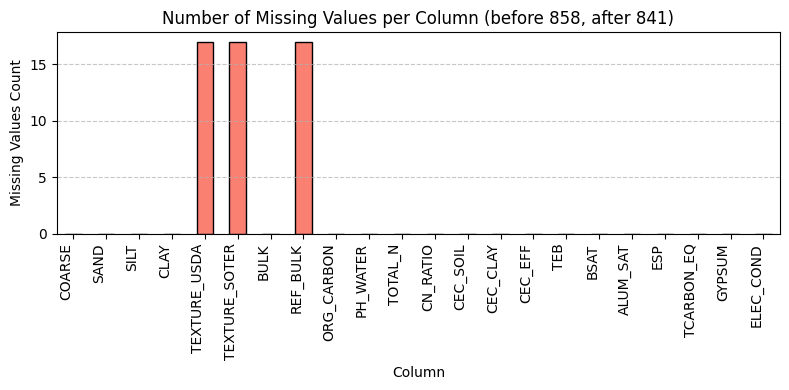

In [3]:

def plot_missing_values(all_cols):
    missing_values_percentage = all_cols.isnull().sum()
    old_number_of_rows = all_cols.shape[0]
    plt.figure(figsize=(8,4))
    missing_values_percentage.plot(kind='bar', color='salmon', edgecolor='black')
    new_number_of_rows = all_cols.dropna().shape[0]

    plt.title(f"Number of Missing Values per Column (before {old_number_of_rows}, after {new_number_of_rows})")
    plt.ylabel("Missing Values Count")
    plt.xlabel("Column")
    plt.xticks(rotation=90, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_missing_values(all_cols)


# Fixing Missing values 

C:\Users\pc\AppData\Local\Temp\ipykernel_16564\2859890300.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_cols["TEXTURE_SOTER"].fillna(all_cols["TEXTURE_SOTER"].mode()[0], inplace=True)


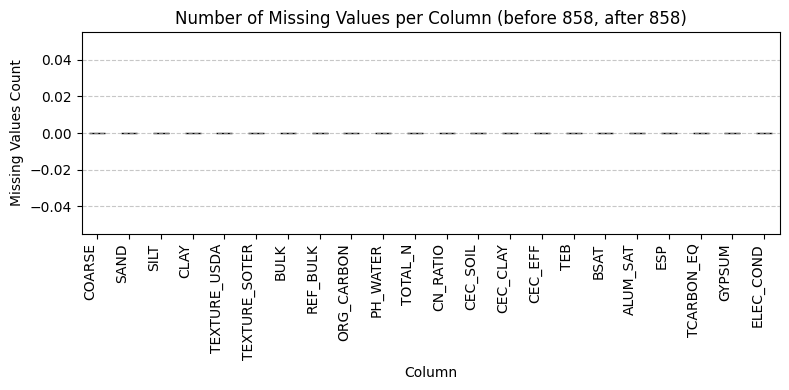

In [4]:
numeric_cols = all_cols.select_dtypes(include=['number'])
numeric_cols = numeric_cols.fillna(numeric_cols.median())
all_cols.update(numeric_cols)
all_cols["TEXTURE_SOTER"].fillna(all_cols["TEXTURE_SOTER"].mode()[0], inplace=True)
numeric_cols = all_cols.select_dtypes(include=['number'])
plot_missing_values(all_cols)

# Univariate Analysis

In [5]:
print("=== Univariate Analysis === ")
print(f"=== Mean ===\n{numeric_cols.mean()}")
print(f"===  Standard Deviation ===\n{numeric_cols.std()}")
print(f"===  Minimum ===\n{numeric_cols.min()}")
print(f"===  Maximum ===\n{numeric_cols.max()}")
print(f"===  Median ===\n{numeric_cols.median()}")

=== Univariate Analysis === 
=== Mean ===
COARSE          11.784382
SAND            47.068765
SILT            29.511655
CLAY            21.224942
TEXTURE_USDA     8.972028
BULK             1.329837
REF_BULK         1.714522
ORG_CARBON       0.840097
PH_WATER         7.476340
TOTAL_N          0.870070
CN_RATIO         9.709790
CEC_SOIL        15.361305
CEC_CLAY        58.214452
CEC_EFF         36.227273
TEB             35.252914
BSAT            91.510490
ALUM_SAT         0.431235
ESP              6.775058
TCARBON_EQ       9.110956
GYPSUM           4.362238
ELEC_COND        2.096737
dtype: float64
===  Standard Deviation ===
COARSE           9.925340
SAND            15.910959
SILT             8.925622
CLAY            10.293000
TEXTURE_USDA     2.398786
BULK             0.746249
REF_BULK         0.129920
ORG_CARBON       0.947115
PH_WATER         1.727291
TOTAL_N          0.802542
CN_RATIO         2.429577
CEC_SOIL         7.600743
CEC_CLAY        17.014529
CEC_EFF         23.586250
TEB  

# Unique numeric values in integer column 

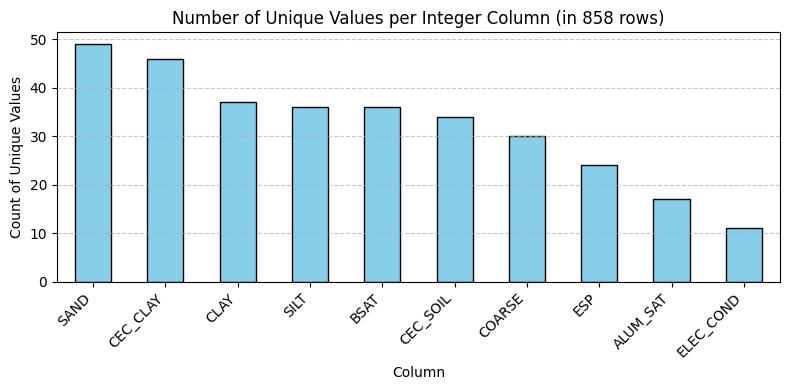

In [6]:

int_cols = numeric_cols.select_dtypes(include="int")
unique_values = int_cols.nunique().sort_values(ascending=False)

plt.figure(figsize=(8,4))
unique_values.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title(f"Number of Unique Values per Integer Column (in {all_cols.shape[0]} rows)")
plt.ylabel("Count of Unique Values")
plt.xlabel("Column")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Value distribution and outliers for numeric columns

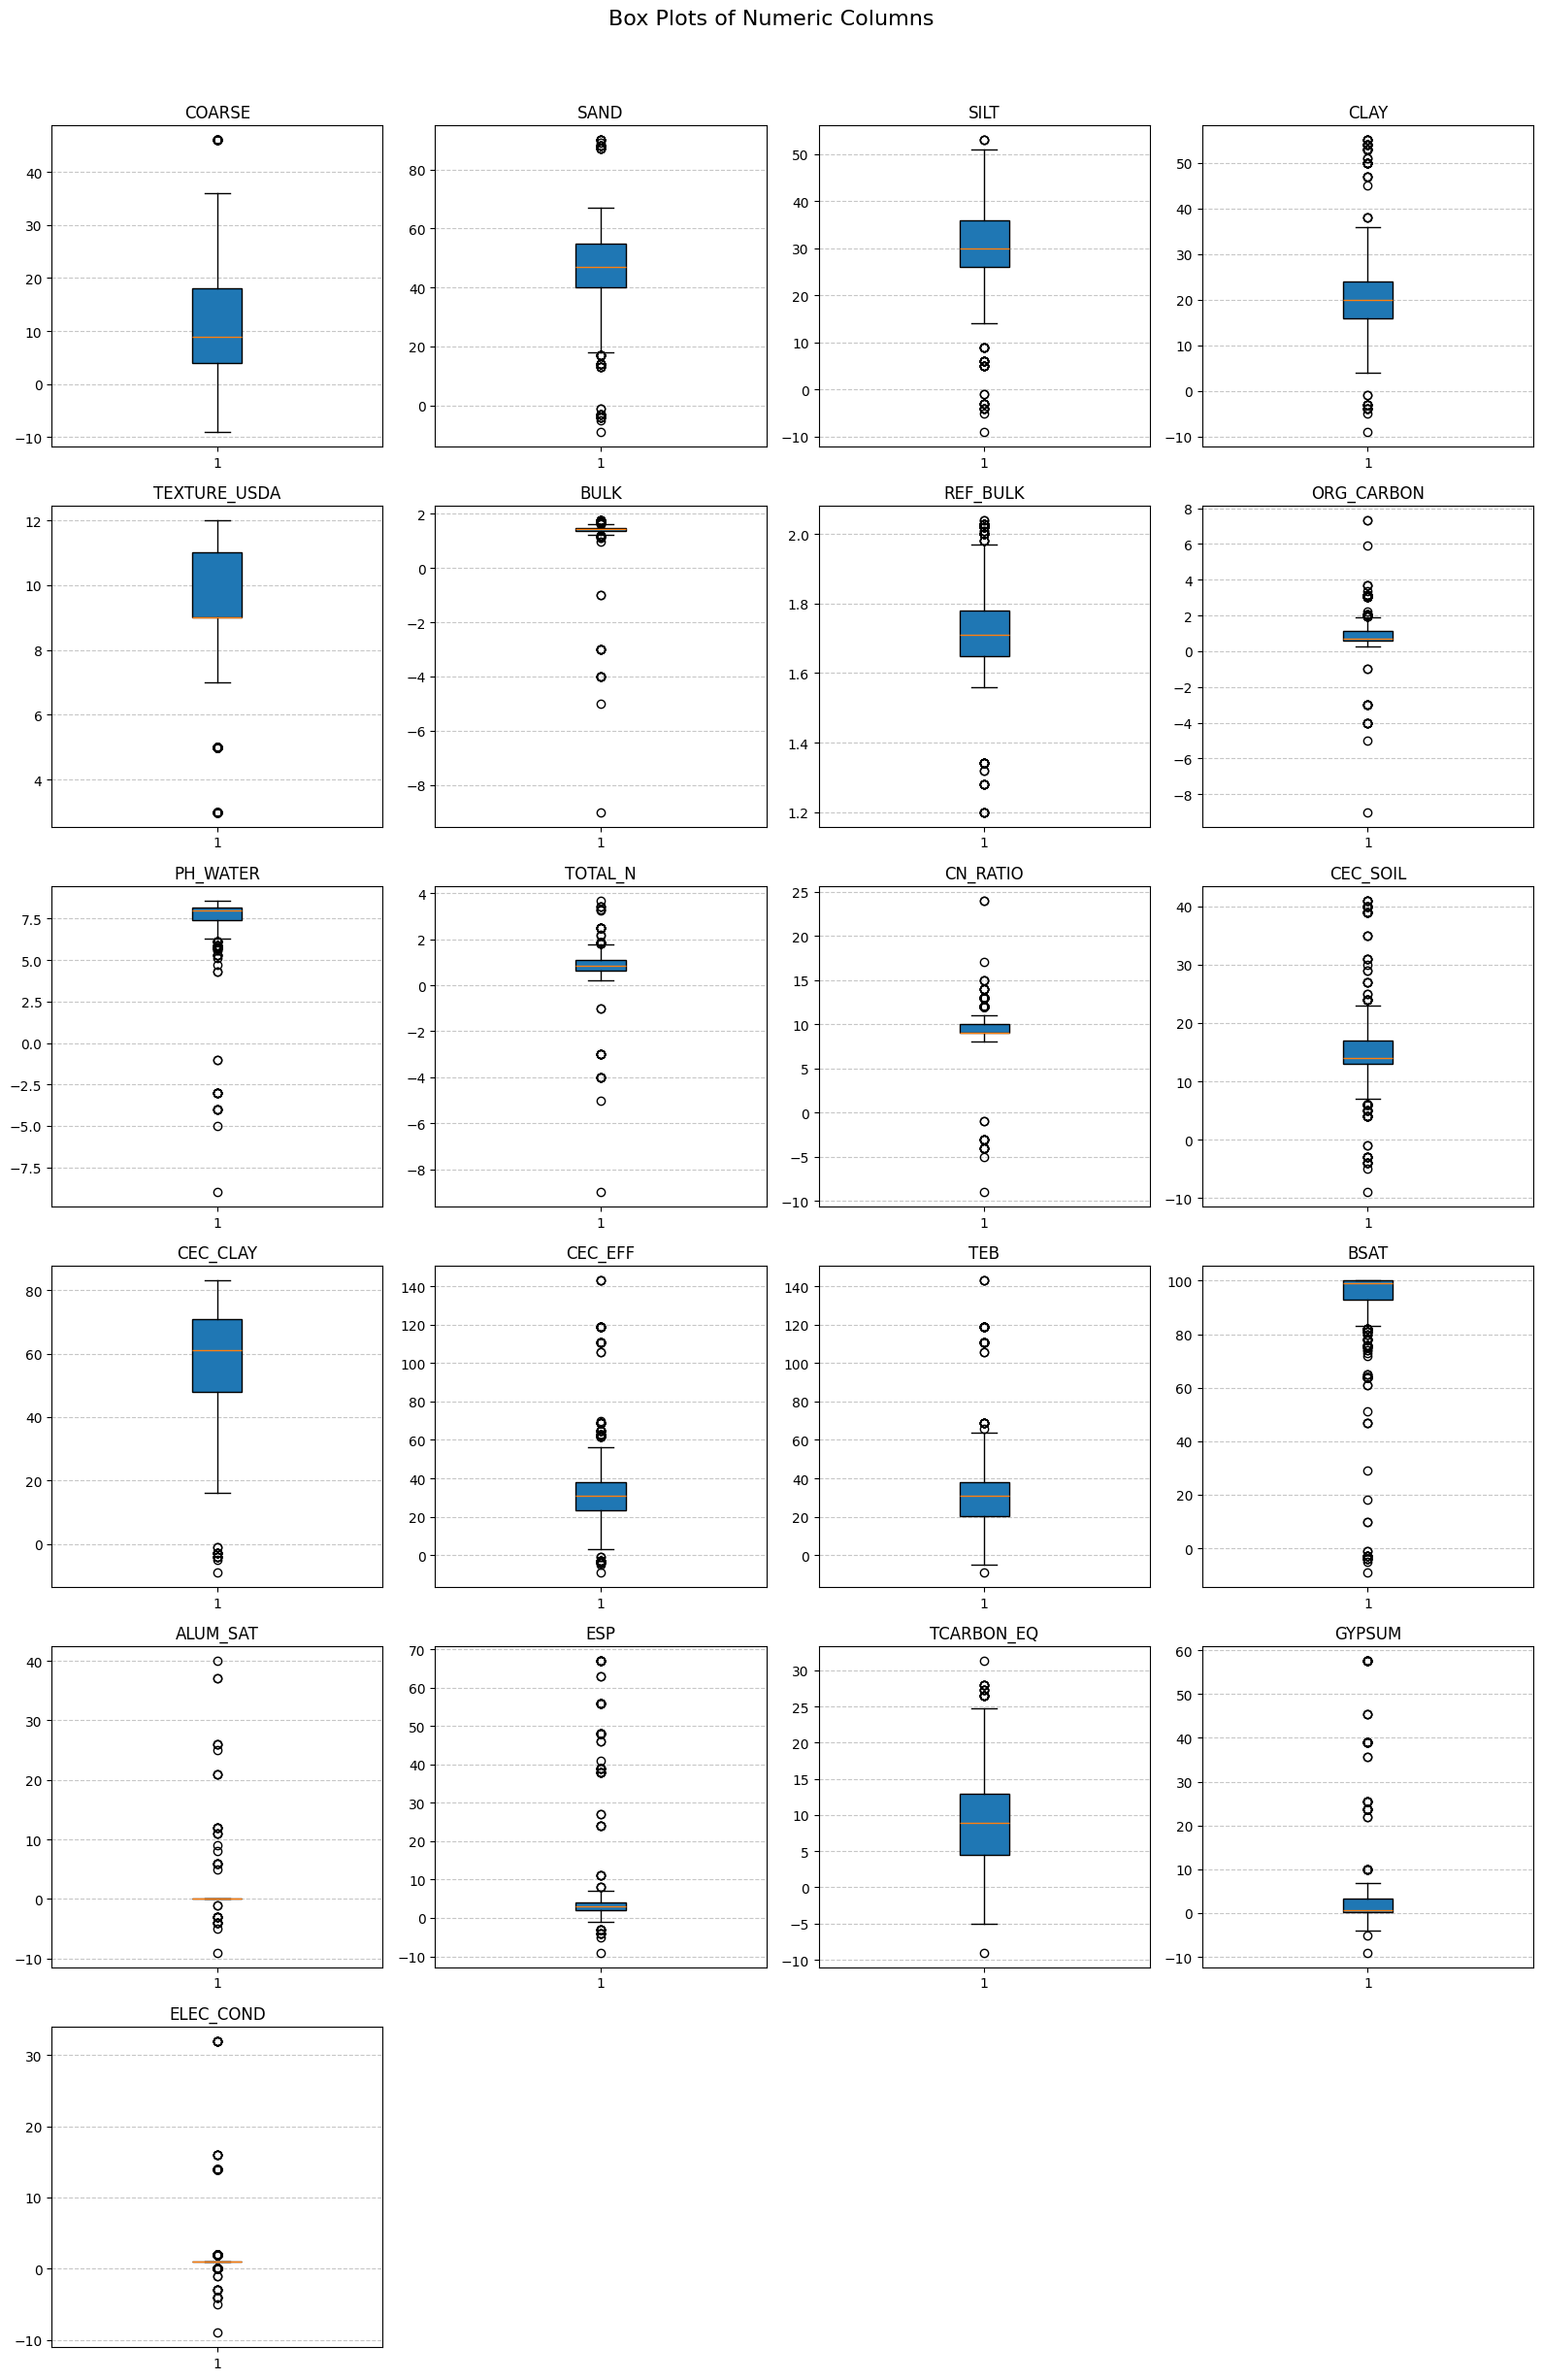

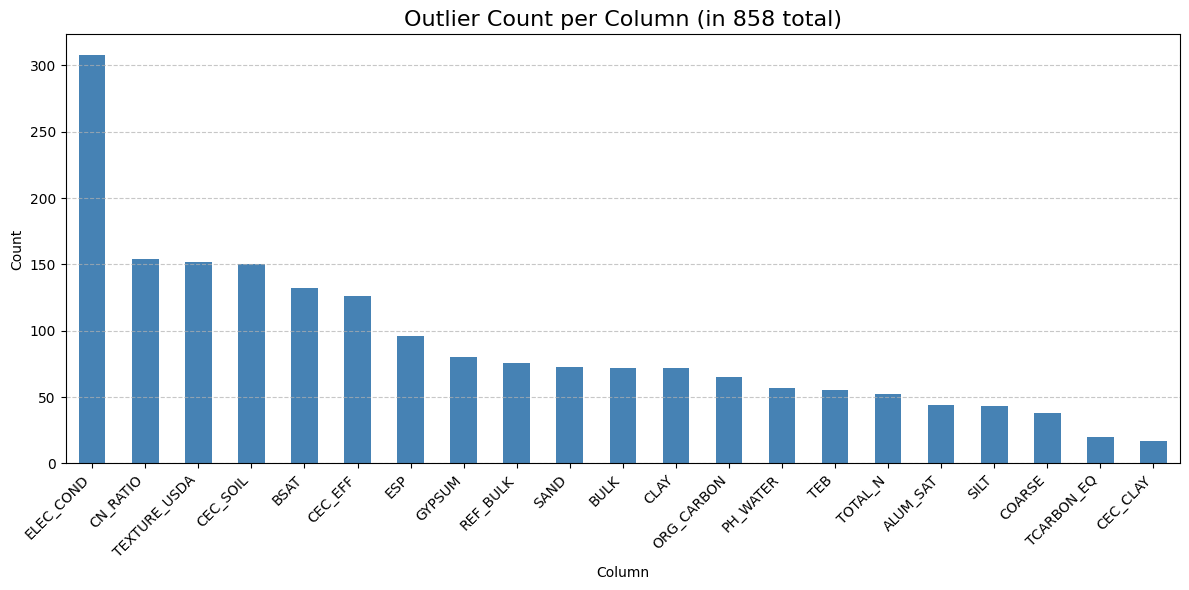

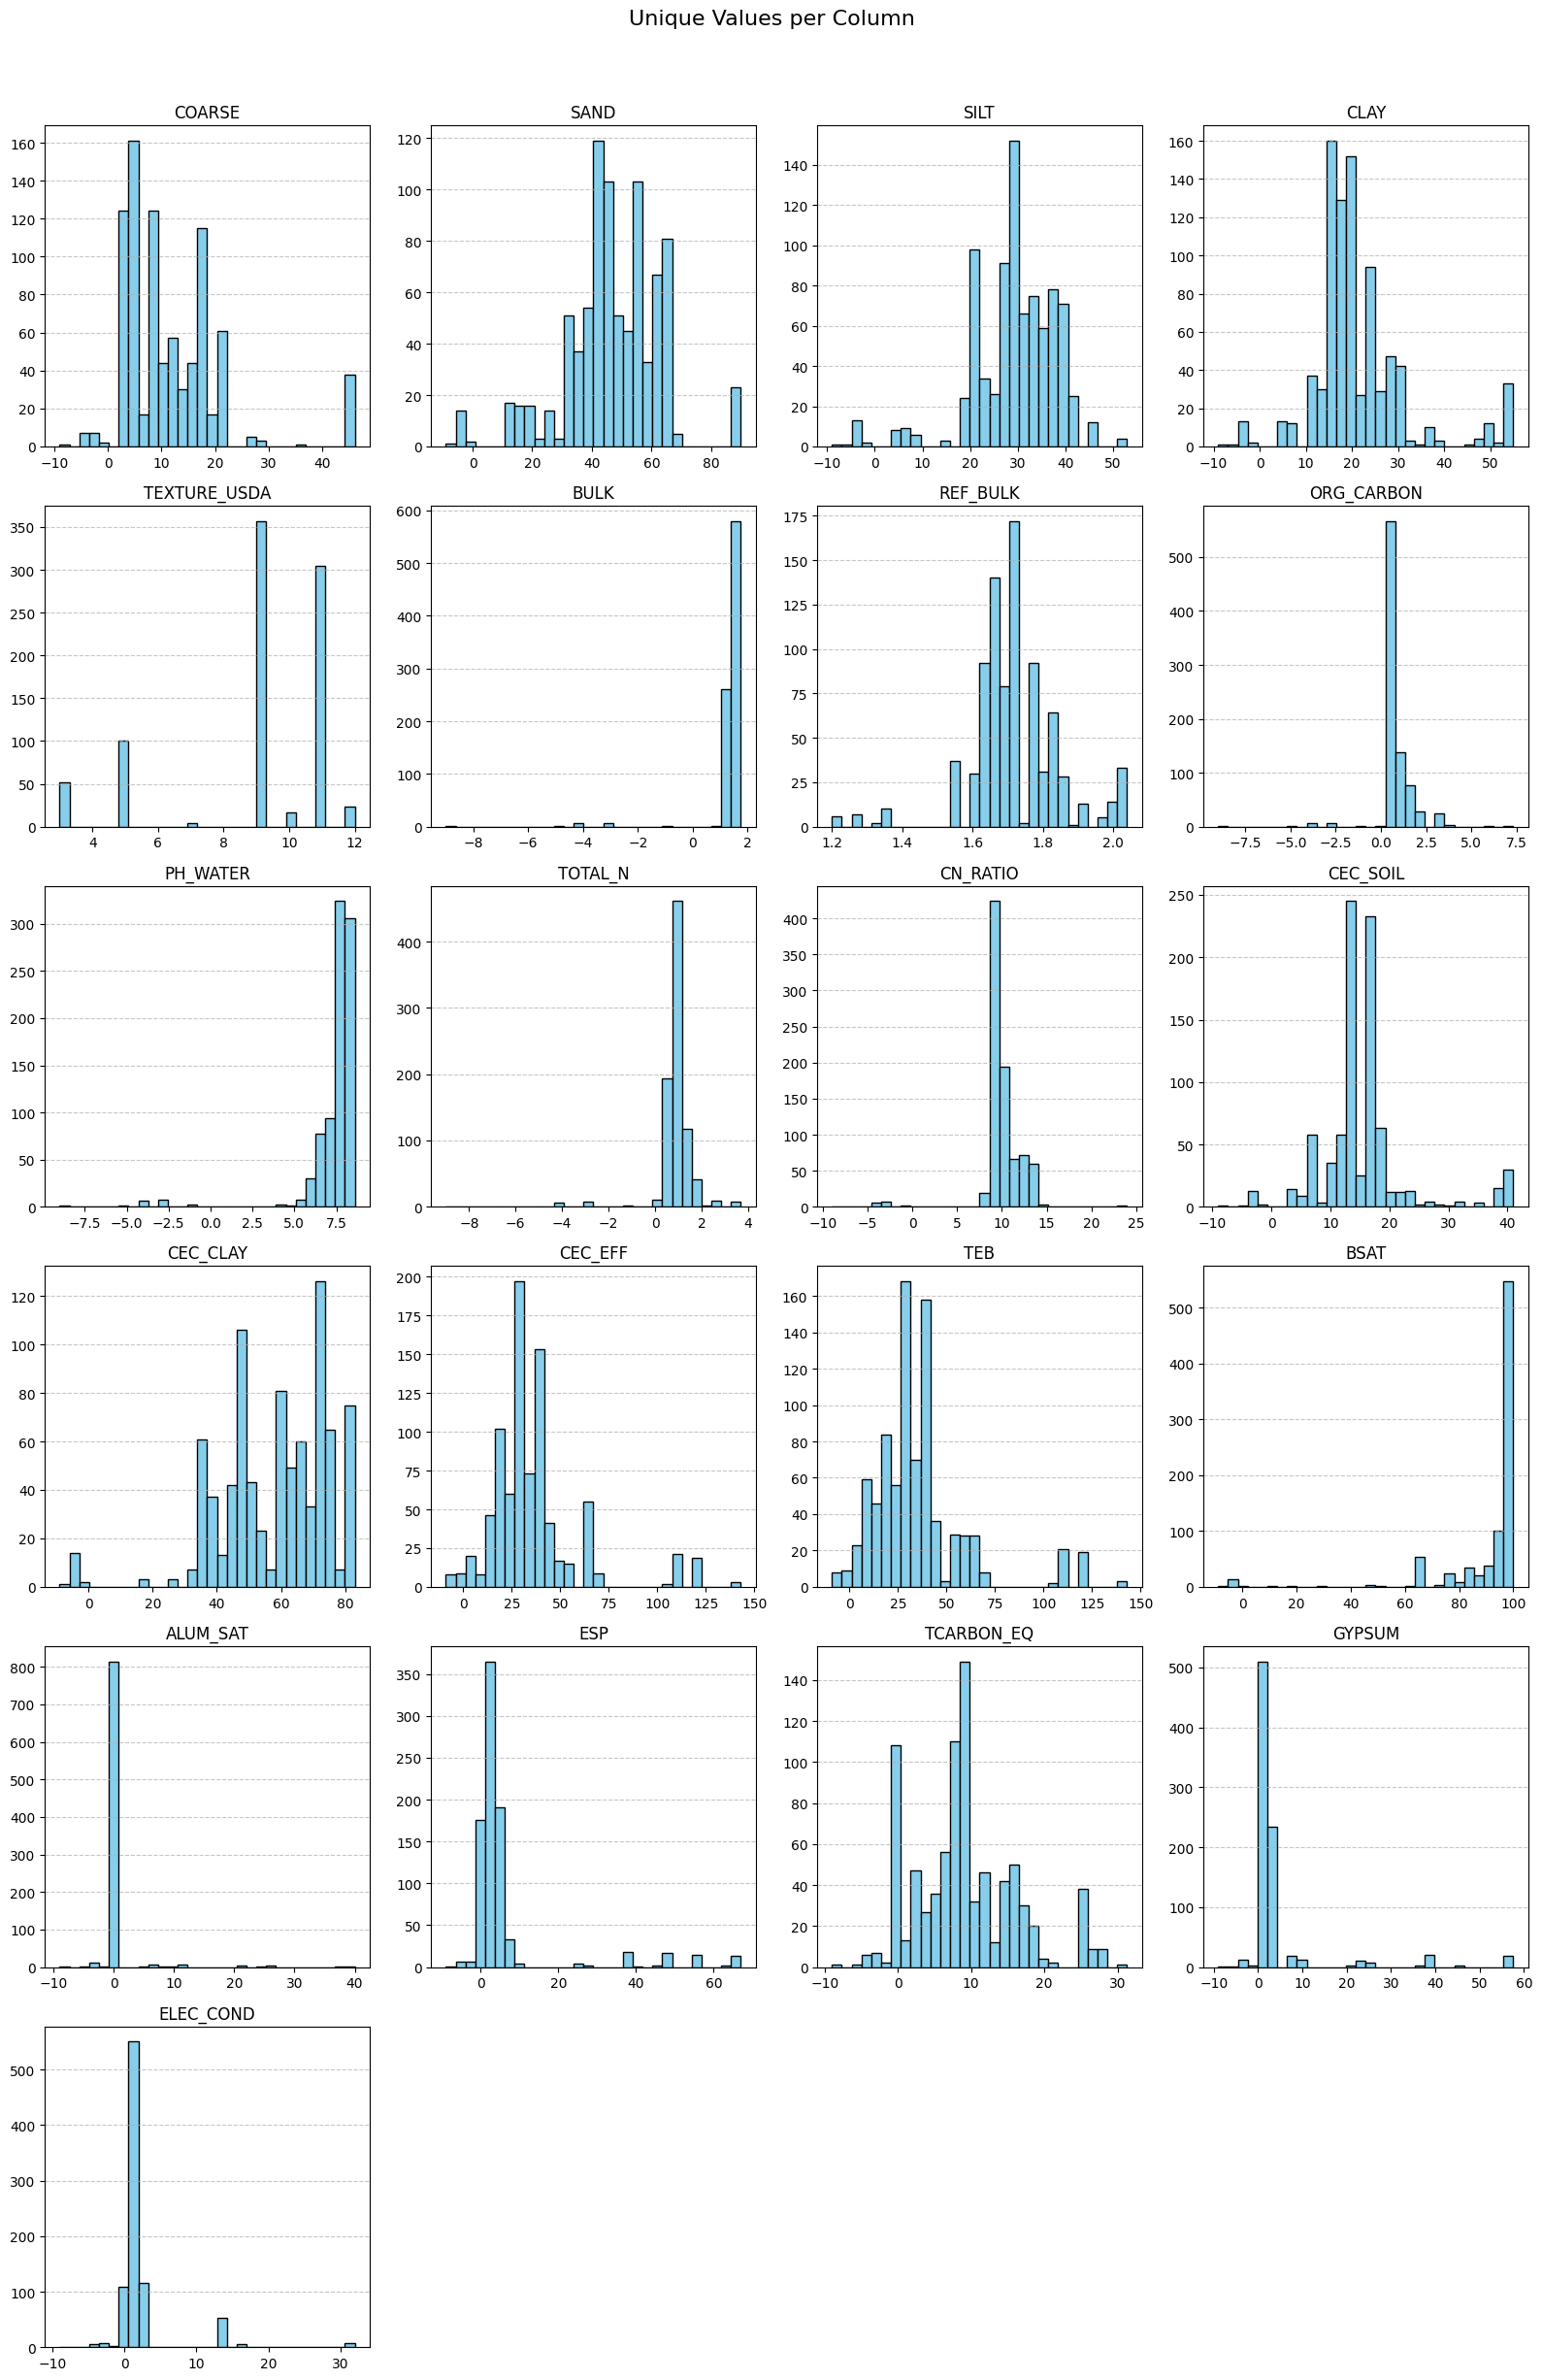

In [ ]:

cols_per_row = 4  # you can change to 3 or 5 depending on your screen

def plot_box_plots(numeric_cols):
    n = len(numeric_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 4, rows * 4))
    plt.suptitle("Box Plots of Numeric Columns", fontsize=16, y=1.02)
    for i, col in enumerate(numeric_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        plt.boxplot(numeric_cols[col], vert=True, patch_artist=True)
        plt.title(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_box_plots(numeric_cols)





Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1
is_outlier = (numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))
outlier_counts = is_outlier.sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
outlier_counts.plot(kind="bar", color="steelblue")
plt.title(f"Outlier Count per Column (in {len(numeric_cols)} total)", fontsize=16)
plt.xlabel("Column")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

def plot_histograms(numeric_cols):
    n = len(numeric_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 4, rows * 4))
    plt.suptitle("Unique Values per Column", fontsize=16, y=1.02)
    for i, col in enumerate(numeric_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        plt.hist(numeric_cols[col], bins=30, color='skyblue', edgecolor='black')
        plt.title(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()



plot_histograms(numeric_cols)

# Fixing Outliers

In [8]:
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# numeric_cols = numeric_cols.clip(lower=lower_bound, upper=upper_bound, axis=1)

# plot_box_plots(numeric_cols)
# plot_histograms(numeric_cols)

# Correlation analysis

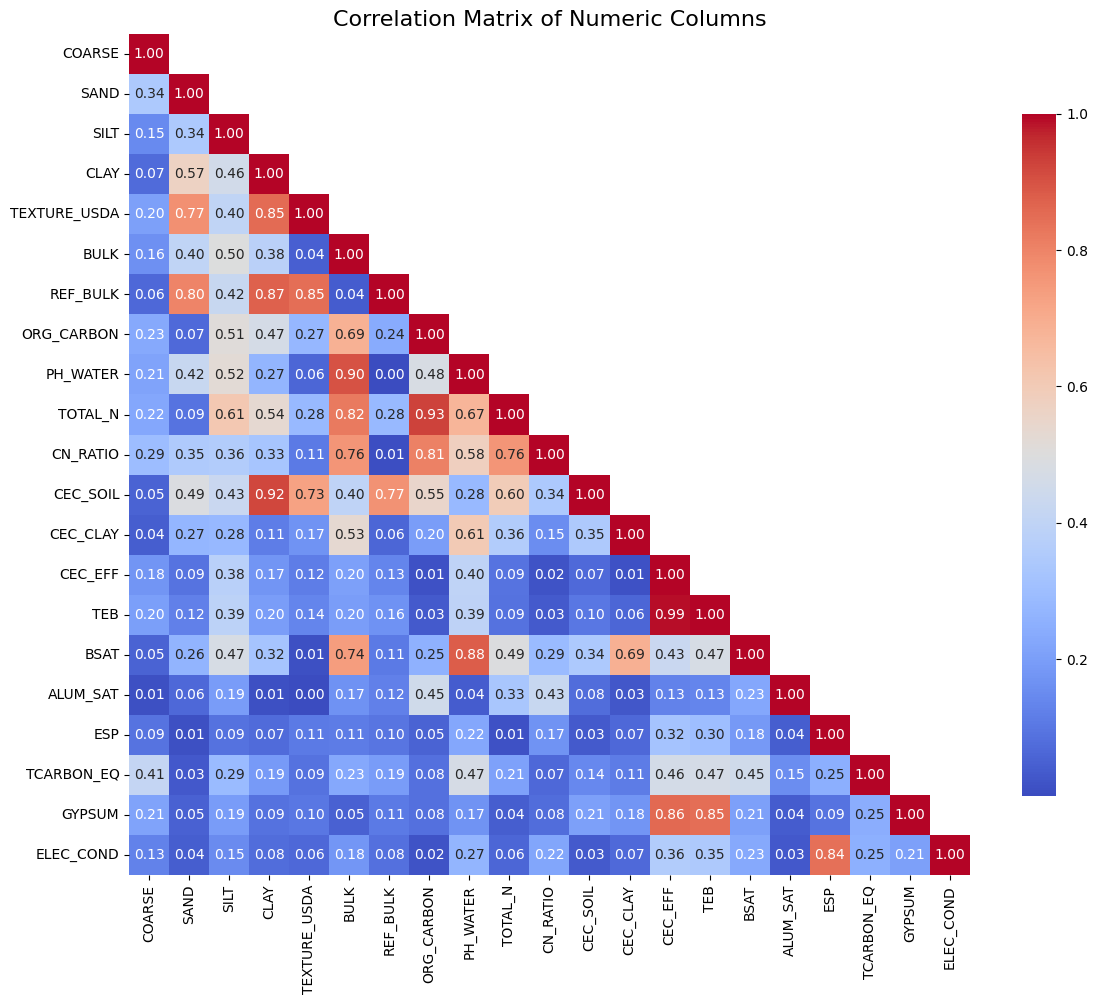

In [9]:

numeric_cols = numeric_cols.loc[:, numeric_cols.nunique() > 1]

# Correlation analysis
correlation_matrix = numeric_cols.corr().abs()

def plot_correlation_matrix(correlation_matrix):
    mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
    plt.title("Correlation Matrix of Numeric Columns", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(correlation_matrix)

# Remove Correleated Features 

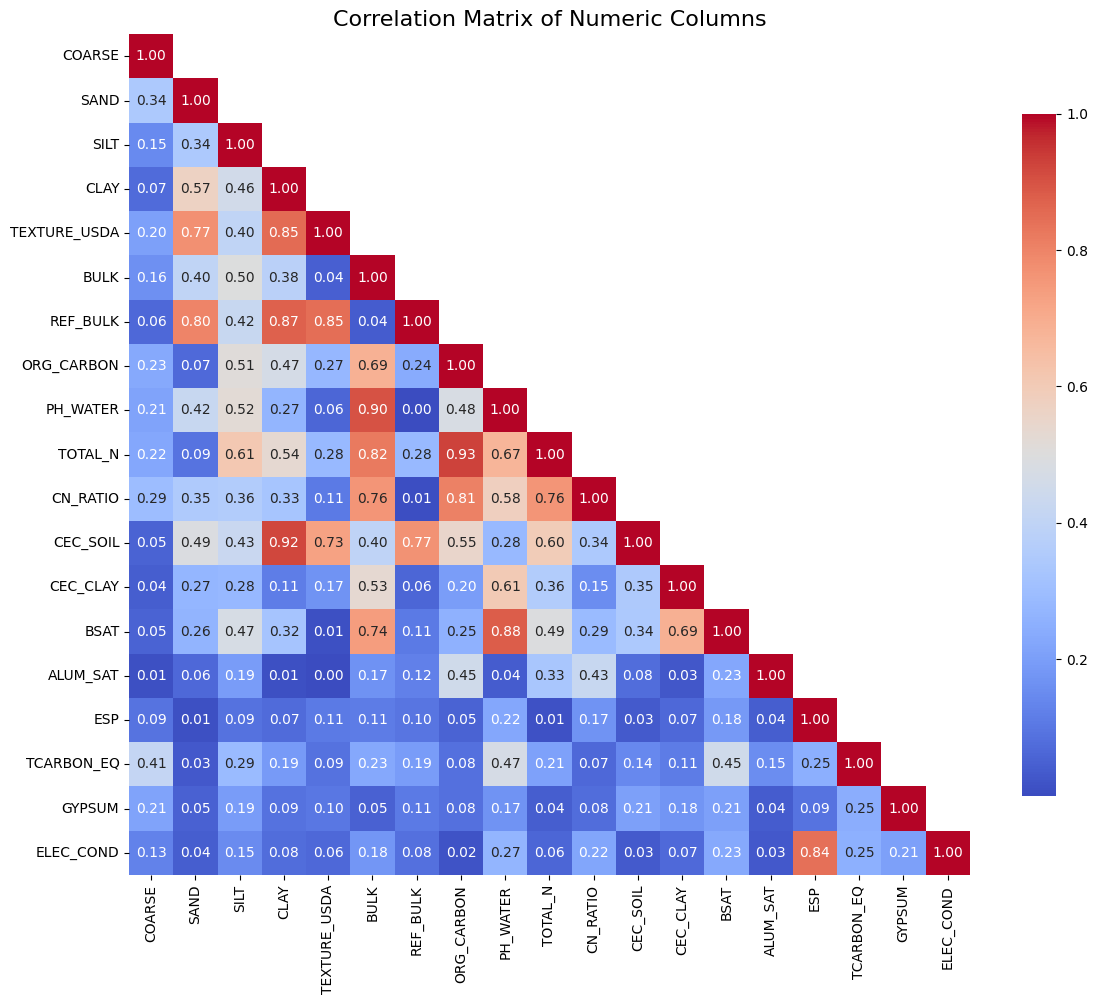

In [10]:
np.fill_diagonal(correlation_matrix.values, 0)
correlated_cols = [col for col in correlation_matrix.columns if any(correlation_matrix[col] > 0.95 )]
new_numeric_cols = numeric_cols.drop(columns=correlated_cols)
plot_correlation_matrix(new_numeric_cols.corr().abs())

# Remerging all columns

In [11]:
all_cols.update(new_numeric_cols)


# Exporting cleaned dataset

In [ ]:

# =========================
# ======= EXPORTING =======
# =========================

# layers.update(all_cols)
# dataset = smu_ids.merge(layers, on="HWSD2_SMU_ID", how="inner")
# dataset = dataset.drop(columns=["HWSD2_SMU_ID"])
# # print("Merging complete.")

# dataset.to_csv(r"../local_dataset/dataset/soil_full.csv", index=False)
# # print("CSV export complete.")

# xarray_dataset_full = xarray.Dataset.from_dataframe(dataset)
# xarray_dataset_full.to_netcdf(r"../local_dataset/dataset/soil_full.nc")
# # print("NetCDF export complete.")

nc_layers_full = xarray.open_dataset(r"../local_dataset/dataset/soil_full.nc")
dataset = nc_layers_full.to_dataframe().reset_index(drop=True)

print(dataset.shape)
# dataset.describe()



(7109938, 25)


,lon,lat,HWSD2_SMU_ID,COARSE,SAND,SILT,CLAY,TEXTURE_USDA,BULK,REF_BULK,...,CEC_SOIL,CEC_CLAY,CEC_EFF,TEB,BSAT,ALUM_SAT,ESP,TCARBON_EQ,GYPSUM,ELEC_COND
count,7.109938e+06,7.109938e+06,7.109938e+06,7.109938e+06,7.109938e+06,7.109938e+06,7.109938e+06,7.109938e+06,7.109938e+06,7.109938e+06,...,7.109938e+06,7.109938e+06,7.109938e+06,7.109938e+06,7.109938e+06,7.109938e+06,7.109938e+06,7.109938e+06,7.109938e+06,7.109938e+06
mean,2.717412e+00,2.853815e+01,3.282813e+03,1.001616e+01,4.386025e+01,2.194465e+01,1.337715e+01,9.725425e+00,4.948776e-01,1.667152e+00,...,9.375985e+00,4.703503e+01,2.832994e+01,2.561363e+01,7.270322e+01,-6.172360e-01,5.221539e+00,6.150633e+00,2.722202e+00,1.196977e+00
std,4.494137e+00,4.613973e+00,7.358259e+03,8.343894e+00,2.492545e+01,1.365545e+01,9.649258e+00,1.526425e+00,1.939905e+00,8.498107e-02,...,7.385051e+00,2.857379e+01,2.451656e+01,2.544600e+01,3.906356e+01,1.631018e+00,1.253542e+01,6.376625e+00,8.228503e+00,4.106290e+00
min,-8.679167e+00,1.906250e+01,3.600000e+01,-9.000000e+00,-9.000000e+00,-9.000000e+00,-9.000000e+00,3.000000e+00,-9.000000e+00,1.200000e+00,...,-9.000000e+00,-9.000000e+00,-9.000000e+00,-9.000000e+00,-9.000000e+00,-9.000000e+00,-9.000000e+00,-9.000000e+00,-9.000000e+00,-9.000000e+00
25%,-2.958333e-01,2.472083e+01,1.312000e+03,3.000000e+00,4.000000e+01,2.000000e+01,1.200000e+01,9.000000e+00,1.350000e+00,1.610000e+00,...,6.000000e+00,3.500000e+01,2.000000e+01,1.000000e+01,6.400000e+01,0.000000e+00,2.000000e+00,1.800000e+00,2.000000e-01,1.000000e+00
50%,2.987500e+00,2.821250e+01,1.808000e+03,1.200000e+01,4.900000e+01,2.700000e+01,1.500000e+01,9.000000e+00,1.420000e+00,1.670000e+00,...,1.300000e+01,5.000000e+01,2.500000e+01,2.000000e+01,9.800000e+01,0.000000e+00,3.000000e+00,6.300000e+00,3.000000e-01,1.000000e+00
75%,6.220833e+00,3.249583e+01,1.843000e+03,1.800000e+01,6.600000e+01,3.100000e+01,1.800000e+01,1.100000e+01,1.450000e+00,1.710000e+00,...,1.400000e+01,7.400000e+01,3.700000e+01,3.800000e+01,1.000000e+02,0.000000e+00,3.000000e+00,1.130000e+01,4.000000e+00,1.000000e+00
max,1.199583e+01,3.732083e+01,3.205000e+04,4.600000e+01,9.000000e+01,5.300000e+01,5.500000e+01,1.200000e+01,1.760000e+00,2.040000e+00,...,4.100000e+01,8.300000e+01,1.430000e+02,1.430000e+02,1.000000e+02,4.000000e+01,6.700000e+01,3.130000e+01,5.760000e+01,3.200000e+01


# Checking the data after export

In [15]:
print("=== Checking the data after export === ")
print("=== Missing Values === ")
print(dataset.isnull().sum())

=== Checking the data after export === 
=== Missing Values === 
lon              0
lat              0
HWSD2_SMU_ID     0
COARSE           0
SAND             0
SILT             0
CLAY             0
TEXTURE_USDA     0
TEXTURE_SOTER    0
BULK             0
REF_BULK         0
ORG_CARBON       0
PH_WATER         0
TOTAL_N          0
CN_RATIO         0
CEC_SOIL         0
CEC_CLAY         0
CEC_EFF          0
TEB              0
BSAT             0
ALUM_SAT         0
ESP              0
TCARBON_EQ       0
GYPSUM           0
ELEC_COND        0
dtype: int64
